In [1]:
import torch
import numpy as np
import glob
import os
import random
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline

from torch import nn

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

used some code from: https://github.com/seyma-tas/Brain-Tumor-Segmentation-Project/blob/master/2AdamW_DICE_BrainTumorGenesis.ipynb
also used: https://github.com/MrGiovanni/ModelsGenesis

# Accuracy and Loss Metrics

In [2]:
def dice_metric(inputs, target):
    intersection = 2.0 * (target * inputs).sum()
    union = target.sum() + inputs.sum()
    if target.sum() == 0 and inputs.sum() == 0:
        return 1.0

    return intersection / union

def dice_loss(inputs, target):
    num = target.size(0)
    inputs = inputs.reshape(num, -1)
    target = target.reshape(num, -1)
    smooth = 1.0
    intersection = (inputs * target)
    dice = (2. * intersection.sum(1) + smooth) / (inputs.sum(1) + target.sum(1) + smooth)
    dice = 1 - dice.sum() / num
    return dice

def bce_dice_loss(inputs, target):
    dicescore = dice_loss(inputs, target)
    bcescore = nn.BCELoss()
    bceloss = bcescore(inputs, target)

    return bceloss + dicescore

# Model
From https://github.com/MrGiovanni/ModelsGenesis

In [3]:


class ContBatchNorm2d(nn.modules.batchnorm._BatchNorm):
    def _check_input_dim(self, input):

        if input.dim() != 4:
            raise ValueError('expected 4D input (got {}D input)'.format(input.dim()))
        #super(ContBatchNorm3d, self)._check_input_dim(input)

    def forward(self, input):
        self._check_input_dim(input)
        return F.batch_norm(
            input, self.running_mean, self.running_var, self.weight, self.bias,
            True, self.momentum, self.eps)


class LUConv(nn.Module):
    def __init__(self, in_chan, out_chan, act):
        super(LUConv, self).__init__()
        self.conv1 = nn.Conv2d(in_chan, out_chan, kernel_size=3, padding=1)
        self.bn1 = ContBatchNorm2d(out_chan)

        if act == 'relu':
            self.activation = nn.ReLU(out_chan)
        elif act == 'prelu':
            self.activation = nn.PReLU(out_chan)
        elif act == 'elu':
            self.activation = nn.ELU(inplace=True)
        else:
            raise

    def forward(self, x):
        out = self.activation(self.bn1(self.conv1(x)))
        return out


def _make_nConv(in_channel, depth, act, double_chnnel=False):
    if double_chnnel:
        layer1 = LUConv(in_channel, 32 * (2 ** (depth+1)),act)
        layer2 = LUConv(32 * (2 ** (depth+1)), 32 * (2 ** (depth+1)),act)
    else:
        layer1 = LUConv(in_channel, 32*(2**depth),act)
        layer2 = LUConv(32*(2**depth), 32*(2**depth)*2,act)

    return nn.Sequential(layer1,layer2)

class DownTransition(nn.Module):
    def __init__(self, in_channel,depth, act):
        super(DownTransition, self).__init__()
        self.ops = _make_nConv(in_channel, depth,act)
        self.maxpool = nn.MaxPool2d(2)
        self.current_depth = depth

    def forward(self, x):
        if self.current_depth == 3:
            out = self.ops(x)
            out_before_pool = out
        else:
            out_before_pool = self.ops(x)
            out = self.maxpool(out_before_pool)
        return out, out_before_pool

class UpTransition(nn.Module):
    def __init__(self, inChans, outChans, depth,act):
        super(UpTransition, self).__init__()
        self.depth = depth
        self.up_conv = nn.ConvTranspose2d(inChans, outChans, kernel_size=2, stride=2)
        self.ops = _make_nConv(inChans+ outChans//2,depth, act, double_chnnel=True)

    def forward(self, x, skip_x):
        out_up_conv = self.up_conv(x)
        concat = torch.cat((out_up_conv,skip_x),1)
        out = self.ops(concat)
        return out


class OutputTransition(nn.Module):
    def __init__(self, inChans, n_labels):

        super(OutputTransition, self).__init__()
        self.final_conv = nn.Conv2d(inChans, n_labels, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.sigmoid(self.final_conv(x))
        return out

class UNet2D(nn.Module):
    # the number of convolutions in each layer corresponds
    # to what is in the actual prototxt, not the intent
    def __init__(self, n_class=1, n_channels=1, act='relu'):
        super(UNet2D, self).__init__()

        self.down_tr64 = DownTransition(n_channels,0,act)
        self.down_tr128 = DownTransition(64,1,act)
        self.down_tr256 = DownTransition(128,2,act)
        self.down_tr512 = DownTransition(256,3,act)

        self.up_tr256 = UpTransition(512, 512,2,act)
        self.up_tr128 = UpTransition(256,256, 1,act)
        self.up_tr64 = UpTransition(128,128,0,act)
        self.out_tr = OutputTransition(64, n_class)

    def forward(self, x):
        self.out64, self.skip_out64 = self.down_tr64(x)
        self.out128,self.skip_out128 = self.down_tr128(self.out64)
        self.out256,self.skip_out256 = self.down_tr256(self.out128)
        self.out512,self.skip_out512 = self.down_tr512(self.out256)

        self.out_up_256 = self.up_tr256(self.out512,self.skip_out256)
        self.out_up_128 = self.up_tr128(self.out_up_256, self.skip_out128)
        self.out_up_64 = self.up_tr64(self.out_up_128, self.skip_out64)
        self.out = self.out_tr(self.out_up_64)

        return self.out



# Load and define dataset


In [4]:
class DatasetSegmentation(torch.utils.data.Dataset):
    def __init__(self, folder_path, interp_size = 512):
        super(DatasetSegmentation, self).__init__()
        self.interp_size = interp_size
        self.img_files = glob.glob(os.path.join(folder_path,'features','*.npy'))
        self.mask_files = []
        for img_path in self.img_files:
             self.mask_files.append(os.path.join(folder_path,'masks',os.path.basename(img_path)) )

    def __getitem__(self, index):
        img_path = self.img_files[index]
        mask_path = self.mask_files[index]

        data = np.load(img_path)
        label = np.load(mask_path)

        data = torch.from_numpy(data).float()
        label = torch.from_numpy(label).float()
        data = F.interpolate(data.unsqueeze(0), (self.interp_size, self.interp_size)).squeeze(0)
        label = F.interpolate(label.unsqueeze(0), (self.interp_size, self.interp_size)).squeeze(0)
        return data, label

    def __len__(self):
        return len(self.img_files)

In [5]:
ds_train = DatasetSegmentation(os.path.join('data', 'yeast_processed_norm_area_50', 'train'))
ds_test = DatasetSegmentation(os.path.join('data', 'yeast_processed_norm_area_50', 'test'))
ds_val = DatasetSegmentation(os.path.join('data', 'yeast_processed_norm_area_50', 'val'))

In [6]:
ds_train.__len__(), ds_test.__len__()

(892, 111)

In [7]:
sample = ds_train.__getitem__(12)

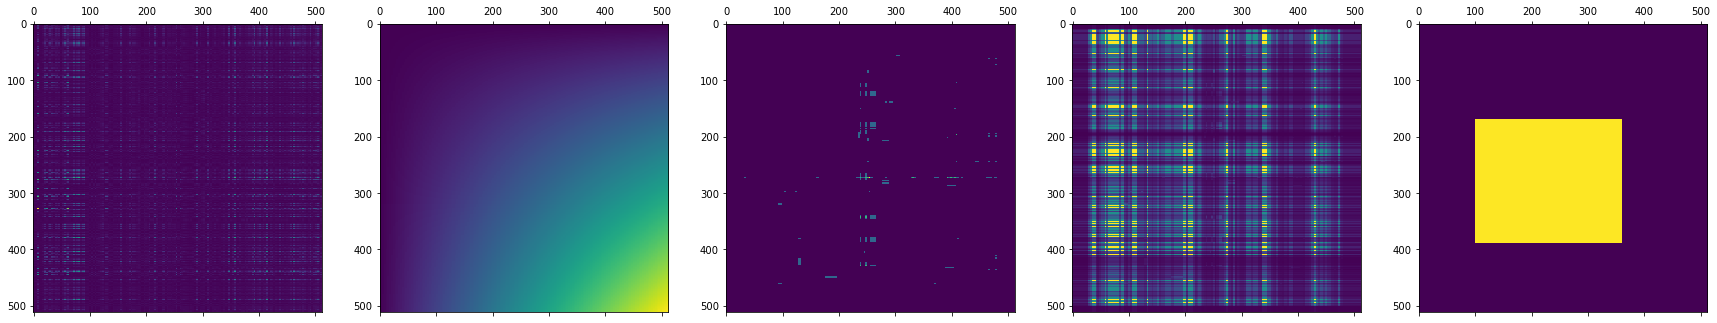

In [8]:
fig, axs = plt.subplots(1,5, figsize=(30,30))
axs[0].matshow(sample[0][0].view(512,512))
axs[1].matshow(sample[0][1].view(512,512))
axs[2].matshow(sample[0][2].view(512,512))
axs[3].matshow(sample[0][3].view(512,512))
axs[4].matshow(sample[1][0].view(512,512))
plt.show()

In [9]:
train_dataloader = torch.utils.data.DataLoader(ds_train, batch_size=2, num_workers=0, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(ds_test, batch_size=2, num_workers=0, shuffle=False)
val_dataloader = torch.utils.data.DataLoader(ds_val, batch_size=2, num_workers=0, shuffle=False)

# Setup Model 

In [10]:
model = UNet2D(n_class=sample[1].shape[0], n_channels=sample[0].shape[0])

## Parameters
Setup loss function:

In [11]:
def dice_metric(inputs, target):
    intersection = 2.0 * (target * inputs).sum()
    union = target.sum() + inputs.sum()
    if target.sum() == 0 and inputs.sum() == 0:
        return 1.0

    return intersection / union

def dice_loss(inputs, target):
    num = target.size(0)
    inputs = inputs.reshape(num, -1)
    target = target.reshape(num, -1)
    smooth = 1.0
    intersection = (inputs * target)
    dice = (2. * intersection.sum(1) + smooth) / (inputs.sum(1) + target.sum(1) + smooth)
    dice = 1 - dice.sum() / num
    return dice

def bce_dice_loss(inputs, target):
    dicescore = dice_loss(inputs, target)
    bcescore = nn.BCELoss()
    bceloss = bcescore(inputs, target)

    return bceloss + dicescore

criterion = bce_dice_loss

Setup optimizer

In [12]:
from torch.optim import AdamW
optimizer = AdamW(model.parameters(), lr=0.1)

In [13]:
from torch.optim import lr_scheduler 
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# Prepare Training

In [14]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

## Train

Start train...


Epochs:   0%|          | 0/1000 [00:00<?, ?it/s]

Batch:   0%|          | 0/446 [00:00<?, ?it/s]

epoch 0 train loss 1.3115635246973936 val loss 1.2830541559628077
epoch 1 train loss 1.2836891260382306 val loss 1.2875182735068458
epoch 2 train loss 1.2748035034791236 val loss 1.26703280210495
epoch 3 train loss 1.275254570315237 val loss 1.2698127350636892
epoch 4 train loss 1.2763429027501778 val loss 1.2733570039272308
epoch 5 train loss 1.272007190593155 val loss 1.2692048336778368
epoch 6 train loss 1.2717934544845546 val loss 1.2771580197981425
epoch 7 train loss 1.2741770624045299 val loss 1.270016027348382
epoch 8 train loss 1.2740148452899915 val loss 1.27582505771092
epoch 9 train loss 1.271742901727223 val loss 1.2723341477768761
epoch 10 train loss 1.2697210333272482 val loss 1.2635219118424825
epoch 11 train loss 1.2683236890309595 val loss 1.2619033455848694
epoch 12 train loss 1.265396166275435 val loss 1.2551347081150328
epoch 13 train loss 1.2585737937769013 val loss 1.246857383421489
epoch 14 train loss 1.2548413092245436 val loss 1.2366986721754074
epoch 15 train 

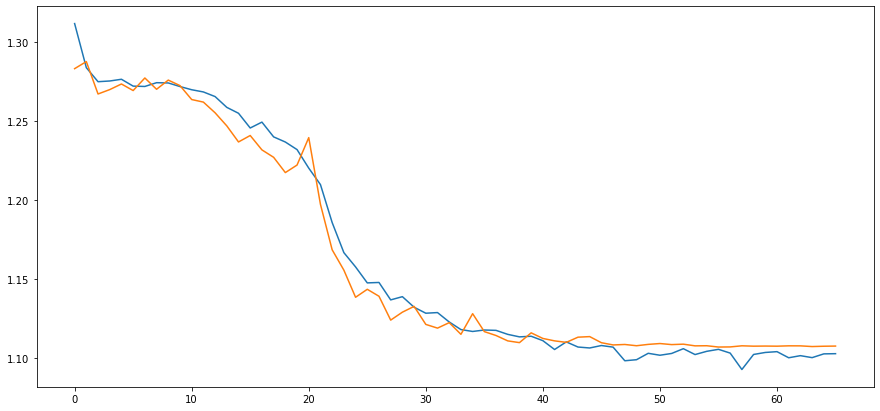

In [15]:
from tqdm.autonotebook import tqdm

epochs = 1000

model.to(device)

# Initialize lists to store loss values
loss_history = []
loss_history_val = []

best_loss_val = float('inf')


early_stop_count = 0
# Train
print("Start train...")
outer = tqdm(total=epochs, desc='Epochs', position=0)
inner = tqdm(total=len(train_dataloader), desc=f'Batch', position=1)
for epoch in range(epochs):
    # check to see if validation loss has plateau'd
    if early_stop_count >= 10:
        print(f'Validation loss plateaud; failed to improve after {early_stop_count} at {epoch}th epoch')
        checkpoint = { 
            'epoch': epoch,
            'model': model,
            'optimizer': optimizer,
            'scheduler': scheduler}
        torch.save(checkpoint, f'./models/unet2D/checkpt_earlystop_{epoch}.pth')
        break
    
    early_stop_count += 1
    
   #Train mode
    model.train()
    loss_running = []
    
    inner.refresh()  #force print final state
    inner.reset()  #reuse bar    
    for _, (x,y) in enumerate(train_dataloader):
        x, y = x.float().to(device), y.float().to(device)
        
        pred = model(x)
        loss = criterion(pred, y)
        loss_running.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        inner.update(1)
        
    loss_history.append(np.mean(loss_running))
    # Evaluate mode
    model.eval()
    with torch.no_grad():
        loss_val_running = []
        for _, (x_val, y_val) in enumerate(val_dataloader):
            x_val, y_val = x_val.to(device), y_val.to(device)
            pred_val = model.forward(x_val) #pred_val = model(x_val)
            loss_val= criterion(pred_val, y_val)
            loss_val_running.append(loss_val.item())
    
    
    curr_loss_val = np.mean(loss_val_running)
    loss_history_val.append(curr_loss_val)
    
    # Change the learning rate
    scheduler.step()
    
    # Save the best weights
    if curr_loss_val < best_loss_val:
        best_loss_val = curr_loss_val
        checkpoint = { 
            'epoch': epoch,
            'model': model,
            'optimizer': optimizer,
            'scheduler': scheduler}
        torch.save(checkpoint, './models/unet2D/best_model.pth')
        early_stop_count = 0
    
    # Save checkpoint every 10
    if epoch % 10 == 0 or epoch >= 1-epochs:
        checkpoint = { 
            'epoch': epoch,
            'model': model,
            'optimizer': optimizer,
            'scheduler': scheduler}
        torch.save(checkpoint, f'./models/unet2D/checkpt{epoch}.pth')
        
    # Print the results    
    outer.update(1)
    print("epoch", epoch, "train loss", loss_history[-1], "val loss", loss_history_val[-1])


# Print loss history
plt.figure(figsize=(15, 7))
plt.plot(loss_history)
plt.plot(loss_history_val)

# Evaluate

In [17]:
checkpoint = torch.load('./models/unet2D/best_model.pth',
                        map_location=torch.device('cpu'))

model = checkpoint['model']
model.cuda()
model.eval()
torch.set_grad_enabled(False)

In [18]:
def plot_mask(mask_cpu, axx, round=False):
    # takes 64*64*64 array
    mask_cpu = mask_cpu.cpu().detach().numpy()
    if round:
        mask_cpu = np.round(mask_cpu)
    axx.matshow(mask_cpu)

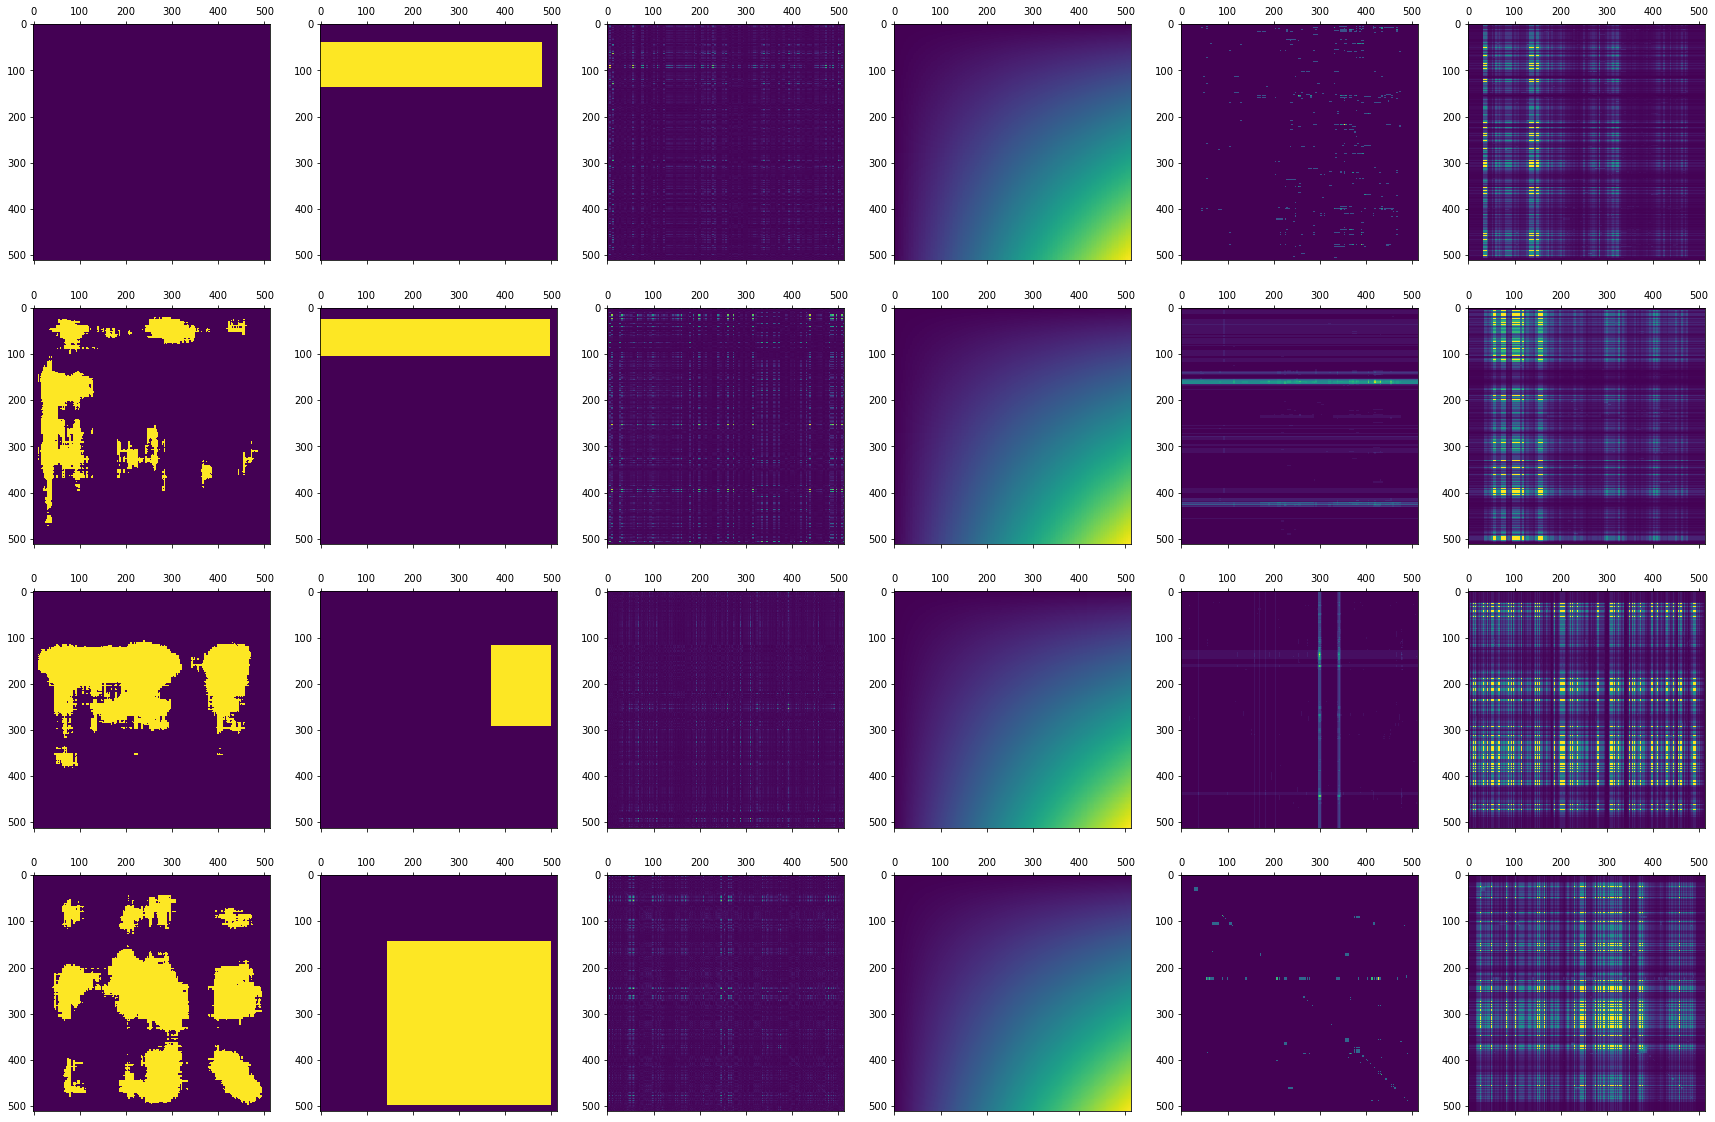

In [19]:
dataloader = test_dataloader
ncol = 6
nrows=4
random.seed(839)
rand_ndx = random.sample(range(0, len(dataloader)), nrows)
fig, ax = plt.subplots(nrows=nrows,  ncols=ncol, figsize=(30, 20))
i = 0
for n, (x, y) in enumerate(dataloader):
    x, y = x.to(device), y.to(device)
    if n in rand_ndx:
        pred = model.forward(x)
        plot_mask(pred[0,0,:,:], ax[i][0], round=True)
        plot_mask(y[0,0,:,:], ax[i][1])
        plot_mask(x[0,0,:,:], ax[i][2])
        plot_mask(x[0,1,:,:], ax[i][3])
        plot_mask(x[0,2,:,:], ax[i][4])
        plot_mask(x[0,3,:,:], ax[i][5])
        i+=1

# Function to compute the dice accuracy

In [20]:
def compute_acc(dataloader, model):
    acc = []
    loss = []
    #model.eval()
    #with torch.no_grad():
    for _, (x, y) in enumerate(dataloader):
        x, y = x.to(device), y.to(device)
        pred = model(x)
        loss.append(bce_dice_loss(pred, y).item())
        # loss.append(BCELoss)    
        acc.append(dice_metric(pred.data.cpu().numpy(), y.data.cpu().numpy()))
       
    print(f'Loss: {np.mean(loss)}, Accuracy (dice): {np.mean(acc)}')

# Compute dice accuracy for train, validation and test data

In [21]:
compute_acc(test_dataloader, model)

Loss: 1.1028552800416946, Accuracy (dice): 0.339255111802522


In [22]:
compute_acc(train_dataloader, model)

Loss: 1.0986132144660694, Accuracy (dice): 0.3574487541456131


In [23]:
compute_acc(val_dataloader, model)

Loss: 1.1069982882056917, Accuracy (dice): 0.3434905321232634
